# Solid dosage forms dissolution models

Immediate or extended release drug product are characterized by their Active Pharmaceutical Ingredient (API) dissolution profile, tested according to USP <711> or Ph. Eur. 2.9.3 monographs.

Several models have been proposed to fit the dissolution profile across time, $y(t)$:
* **Weibull Model** based on diffusion: $y(t) = p(1-e^{-zt})$

where $p$ is a *potency factor* (= dissolution plateau fraction value, set to 1 if the total quantity of API is released) and $z$ is a *kinetic dissolution factor* (higher z, faster dissolution).


* **Modified Weibull Model**: $y(t) = p(1-e^{(-zt)^k})$

which introduces an additional *scale factor* $k$, meant to better fit experimentally observed dissolution profiles.


* **Noyes-Whitney Model** expressed by the differential equation: $\frac{dy(t)}{dt} = z(p-y(t))^n (s-y(t)\frac{dose}{v})$

which considers the effect of the API concentration gradient during the dissolution through the term $(s-y(t)\frac{dose}{v})$, where $s$ is the *API solubility* in the dissolution media, $dose$ is the *API dose* in the drug dosage form and $v$ is the *volume* of dissolution media.



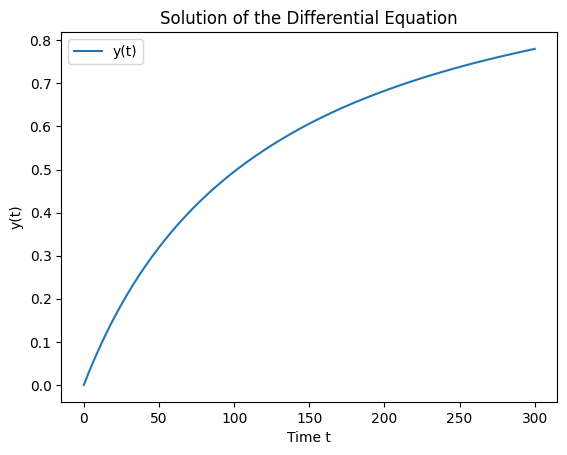

In [442]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the differential equation dy/dt = z * (p - y)^n * (s - y * dose / v)
def dydt(t, y, z, p, n, s, v):
    return z * (p - y)**n * (s - y * dose / v)

# Parameters
z = 0.009   # Adjust based on your specific problem
p = 1.0     # Adjust based on your specific problem
n = 1.33    # Adjust based on your specific problem
s =  1.0    # Adjust based on your specific problem
dose = 0.5  # Adjust based on your specific problem
v = 1.0     # Adjust based on your specific problem

# Initial conditions
y0 = 0   # Initial value of y at t = 0
t_span = (0, 300)  # Time range to solve over (e.g., from t=0 to t=10)
t_eval = np.linspace(t_span[0], t_span[1], t_span[1]+1)  # Points at which to store the solution

# Solve the ODE
sol = solve_ivp(dydt, t_span, [y0], args=(z, p, n, s, v), t_eval=t_eval, method='RK45')

# Plot the solution
plt.plot(sol.t, sol.y[0], label='y(t)')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.title('Solution of the Differential Equation')
plt.legend()
plt.show()


In [443]:
y_data = sol.y[0][np.where(np.isin(sol.t, [0, 90, 240, 270]))] * np.random.default_rng().normal(1, 0.05, 4)
y_data


array([0.        , 0.46764173, 0.77210974, 0.73659371])

Optimal parameters: z = 0.009017433746424162, n = 1.2766693850491817


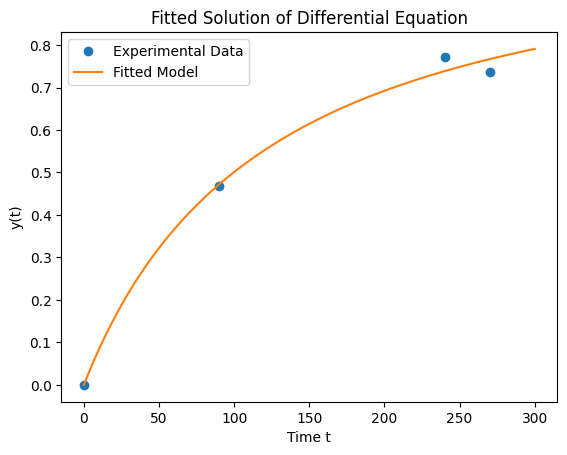

In [444]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the differential equation dy/dt = z * (p - y)**n * (s - y * dose / v)
def dydt(t, y, z, p, n, s, v):
    return z * (p - y)**n * (s - y * dose / v)

# Function to solve the ODE with given parameters z and n
def solve_ode(z, n, p, s, v, y0, t_eval):
    sol = solve_ivp(dydt, (t_eval[0], t_eval[-1]), [y0], args=(z, p, n, s, v), t_eval=t_eval, method='RK45')
    if sol.success and len(sol.y[0]) == len(t_eval):
        return sol.y[0]  # Return only the y values if the solution is successful and matches t_eval length
    else:
        # Return an array of NaNs if the solution fails to avoid shape mismatches in objective function
        return np.full_like(t_eval, np.inf)

# Objective function to minimize the difference between ODE solution and experimental data
def objective(params, t_data, y_data, p, s, v, y0):
    z, n = params  # Unpack parameters
    y_model = solve_ode(z, n, p, s, v, y0, t_data)  # Solve ODE with current parameters
    if np.isnan(y_model).any():  # Check if the solution failed
        return np.inf  # Return a large value if the ODE solver failed
    return np.sum((y_data - y_model)**2)  # Calculate the sum of squared differences

# Experimental data points (t_data, y_data)
t_data = np.array([0, 90, 240, 270])  # Example time points
#y_data = np.array([0.0,  0.63869043,  1.03709023,  0.96924842])  # Example observed values

# Known parameters and initial condition
p = 1.0     # Adjust based on your specific problem
s =  1.0    # Adjust based on your specific problem
dose = 0.5  # Adjust based on your specific problem
v = 1.0     # Adjust based on your specific problem
y0 = 0.    # Initial condition for y

# Initial guess for parameters z and n
initial_guess = [0.01, 1.0]

# Perform the optimization
result = minimize(objective, initial_guess, args=(t_data, y_data, p, s, v, y0), bounds=[(0, None), (0, None)])
z_opt, n_opt = result.x

# Print the fitted parameters
print(f"Optimal parameters: z = {z_opt}, n = {n_opt}")

# Solve the ODE using the optimized parameters and plot with the data
y_fitted = solve_ode(z_opt, n_opt, p, s, v, y0, np.linspace(0, 300, 300+1))

plt.plot(t_data, y_data, 'o', label='Experimental Data')
plt.plot(np.linspace(0, 300, 300+1), y_fitted, '-', label='Fitted Model')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Fitted Solution of Differential Equation')
plt.show()
